# Image Classification of the MNIST and CIFAR-10 datasets: A use-case for convolutional neural networks


# Notebook Initialization

In [2]:
%matplotlib notebook
%autosave 200

Autosaving every 200 seconds


As using the whole database to test the code is highly time consuming, it's possible to toggle a sampling of the database to allow a faster testing of the code

In [1]:
sampling = False
sample_size = 100

In [3]:
import numpy as np #For array and numerical manipulation
import matplotlib as mpl #For plotting and image manipulation
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from sklearn import metrics, datasets, svm, metrics
from sklearn.model_selection import train_test_split

## Defining Functions

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
def random_sampling(imgs, n_labels, labels):
    """
    This function randomly samples a labeled dataset and returns one set made of examples from each label.
    """
    data = []
    label = []
    for i in range(n_labels):
        repeat = True
        while repeat == True:
            idx = np.random.randint(0, imgs.shape[0])
            if labels[idx] == i:
                data.append(imgs[idx])
                label.append(labels[idx])
                repeat = False
    return data, label
    

# Introduction

Due to its many applications, image classification has become one of the core problems that computer vision algorithms tries to address [ref]. 

The whole concept of image classification deals with analyzing a set of labeled images (being single or multi channeled) and creating a model capable of correlating the image with its given label. This model can be used subsequently to analyze an unlabeled image dataset and separate it into different classifications. This process can be applied to different use-cases ranging from face recognition [ref] to disease detection from medical imagery [ref].

Due to the intrinsic properties of images, many challenges arise from working with these datasets, being viewpoint and scale variation, deformation, occlusion, intra-class variation, illumination and noise some common examples. All these challenges lead to decreased accuracies when using classical classification algorithms for the analysis.

The struggle to achieve high accuracy in image classification lead to the development of new classification methods, being convolutional neural networks one of the most ubiquitous when discussing image classifiers.

This report aims to compare the classification performance of common algorithms with that of convolutional neural networks for two benchmark image databases, the MNIST handwritten digits and the CIFAR-10 datasets


## The Datasets

To benchmark the different algorithms, two of the most widely used image datasets were studied in this work, the MNIST and CIFAR-10.

The MNIST database of handwritten digits is composed of a training set of 60,000 labelled images of the digits 0-9 and a set of 10,000 testing images. The digits have been size-normalized and centered in a fixed-size image. It is a dataset that allows the benchmark of different classification methods without major pre-processing required. Fig [1] shows a random class sampling from the MNIST dataset.


Although the MNIST dataset is a good candidate for benchmarking, its simplicity leads to high accuracy even in simple models like the K-Nearest Neighbor. One of the reason is that not only the digits are centered, but also that all digits have a black background, which keeps the main difference between the images in the digits itself. Furthermore, the intraclass shape is mostly similar.

To compare the performance on the MNIST dataset with a more real-world example, the analysis was also carried out in the CIFAR-10 dataset. This dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. In contrast with the MNIST database, the CIFAR-10 dataset has high intraclass variation as well as variations in inter and intraclass backgrounds. Fig[2] shows a random class sampling of the dataset and it’s clear from the samples that the differences between the images are more pronounced than in the MNIST dataset.


### The MNIST Dataset

In [6]:
from keras.datasets import mnist
(X_train_MN, y_train_MN), (X_test_MN, y_test_MN) = mnist.load_data()
print('The shape of the training data is: {}'.format(X_train_MN.shape))
print('The shape of the testing data is: {}'.format(X_test_MN.shape))

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


The shape of the training data is: (60000, 28, 28)
The shape of the testing data is: (10000, 28, 28)


<IPython.core.display.Javascript object>


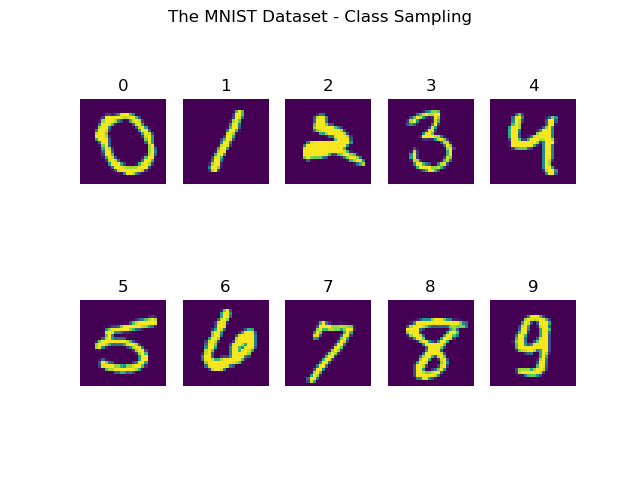

In [7]:
data, label = random_sampling(X_train_MN, 10, y_train_MN)
fig, axis = plt.subplots(2, 5)
axs = axis.ravel()
for i in range(len(axs)):
    axs[i].imshow(data[i])
    axs[i].set_title(label[i])
    axs[i].axis('off')
fig.suptitle('The MNIST Dataset - Class Sampling'.format(i))
plt.show()

In [8]:
X_train_MN, X_val_MN, y_train_MN, y_val_MN = train_test_split(X_train_MN, y_train_MN, 
                                                              test_size=0.3, random_state=0)
X_train_MN = X_train_MN.reshape(X_train_MN.shape[0], 
                                X_train_MN.shape[1] * X_train_MN.shape[2])

X_val_MN = X_val_MN.reshape(X_val_MN.shape[0], 
                                X_val_MN.shape[1] * X_val_MN.shape[2] )

X_test_MN = X_test_MN.reshape(X_test_MN.shape[0], 
                                X_test_MN.shape[1] * X_test_MN.shape[2] )


In [9]:
if sampling == True:
    X_train_MN = X_train_MN[:sample_size]
    y_train_MN = y_train_MN[:sample_size]
    
    X_val_MN = X_val_MN[:sample_size]
    y_val_MN = y_val_MN[:sample_size]
    
    X_test_MN = X_test_MN[:sample_size]
    y_test_MN = y_test_MN[:sample_size]

### The CIFAR-10 Dataset

In [10]:
from keras.datasets import cifar10
(X_train_CF, y_train_CF), (X_test_CF, y_test_CF) = cifar10.load_data()
print('The shape of the training data is: {}'.format(X_train_CF.shape))
print('The shape of the testing data is: {}'.format(X_test_CF.shape))

The shape of the training data is: (50000, 32, 32, 3)
The shape of the testing data is: (10000, 32, 32, 3)


<IPython.core.display.Javascript object>


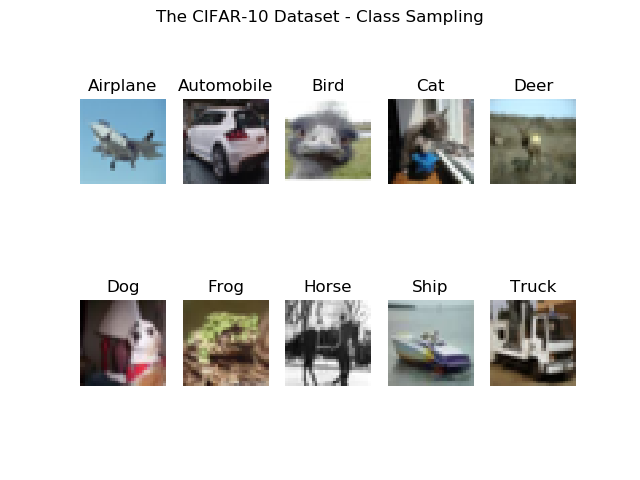

In [11]:
data= random_sampling(X_train_CF, 10, y_train_CF)[0]
label =['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
fig, axis = plt.subplots(2, 5)
axs = axis.ravel()
for i in range(len(axs)):
    axs[i].imshow(data[i])
    axs[i].set_title(label[i])
    axs[i].axis('off')
fig.suptitle('The CIFAR-10 Dataset - Class Sampling'.format(i))
plt.show()

In [12]:
X_train_CF, X_val_CF, y_train_CF, y_val_CF = train_test_split(X_train_CF, y_train_CF, 
                                                              test_size=0.3, random_state=0)
X_train_CF = X_train_CF.reshape(X_train_CF.shape[0], 
                                X_train_CF.shape[1] * X_train_CF.shape[2] * X_train_CF.shape[3])

X_val_CF = X_val_CF.reshape(X_val_CF.shape[0], 
                                X_val_CF.shape[1] * X_val_CF.shape[2] * X_val_CF.shape[3])

X_test_CF = X_test_CF.reshape(X_test_CF.shape[0], 
                                X_test_CF.shape[1] * X_test_CF.shape[2] * X_test_CF.shape[3])

In [13]:
if sampling == True:
    X_train_CF = X_train_CF[:sample_size]
    y_train_CF = y_train_CF[:sample_size]
    
    X_val_CF = X_val_CF[:sample_size]
    y_val_CF = y_val_CF[:sample_size]
    
    X_test_CF = X_test_CF[:sample_size]
    y_test_CF = y_test_CF[:sample_size]

## The Algorithms

In this work three methods were used to classify the dataset, the K-Nearest Neighbour (KNN), the Multilayer Perceptron (MLP) and the Convolutional Neural Network (CNN) classifiers.

The KNN algorithm calculates the Euclidian (L2) distance between the image and a training dataset to find the image that most closely resembles the image to be classified, which is called the nearest neighbour (NN). The classifier will then yield the same label to the image as its NN. Even with its simplicity, this classifier can be very useful when comparing similar images (like the MNIST dataset) and thus is used in this work as the baseline. The KNN implementation used in this work comes from Python’s SciKit Learn package with K = 5.

To serve as a baseline for the use of neural networks for image classification, a MLP with one hidden layer was chosen. The model is a simple neural network with one hidden layer with the same number of neurons as there are inputs. A rectifier activation function is used for the neurons in the hidden layer.

A softmax activation function is used on the output layer to turn the outputs into probability-like values and allow one class of the 10 to be selected as the model’s output prediction. Logarithmic loss is used as the loss function and the ADAM gradient descent algorithm is used to learn the weights. The model is fit over 10 epochs with updates every 200 images. 
The last classifier used in this work was an example of a convolutional neural network. In this case the image serves as input to different convolution filter layers that serve as feature extractors. The output from the convolutional layers in them vectorized and taken by a fully connected neural network for classification. 
The CNN architecture used in this work consists of:
1.	A hidden convolutional layer with 32 feature maps, each with size of 5×5 and a rectifier activation function.
2.	A max pooling layer. 
3.	A regularization layer using 20% dropout in order to reduce overfitting.
4.	A layer that converts the 2D matrix data to a vector called.
5.	A fully connected layer with 128 neurons and rectifier activation function.
6.	The output layer with 10 neurons for the 10 classes and a softmax activation function to output probability-like predictions for each class.

As before, the model is trained using logarithmic loss and the ADAM gradient descent algorithm. Both the MLP and the CNN models were implemented by using Python’s Keras package with Tensor Flow backend.


### K-Nearest Neighbour Algorithm

In [14]:
from sklearn.neighbors import KNeighborsClassifier

### Multi-Layer Perceptron

In [15]:
from sklearn.neural_network import MLPClassifier

### Convolutional Neural Networks

In [16]:
import keras as kr
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K
K.set_image_dim_ordering('th')

# Implementation & Results

## KNN Implementation - Baseline

### MNIST

In [17]:
%%time
knn = KNeighborsClassifier()
knn.fit(X_train_MN, y_train_MN)
results = knn.predict(X_test_MN)

Wall time: 10min 22s


In [18]:
print(metrics.classification_report(y_test_MN, results))

             precision    recall  f1-score   support

          0       0.96      0.99      0.98       980
          1       0.95      1.00      0.97      1135
          2       0.98      0.95      0.97      1032
          3       0.96      0.96      0.96      1010
          4       0.98      0.96      0.97       982
          5       0.96      0.96      0.96       892
          6       0.98      0.99      0.98       958
          7       0.96      0.96      0.96      1028
          8       0.98      0.92      0.95       974
          9       0.95      0.95      0.95      1009

avg / total       0.97      0.97      0.97     10000



<IPython.core.display.Javascript object>


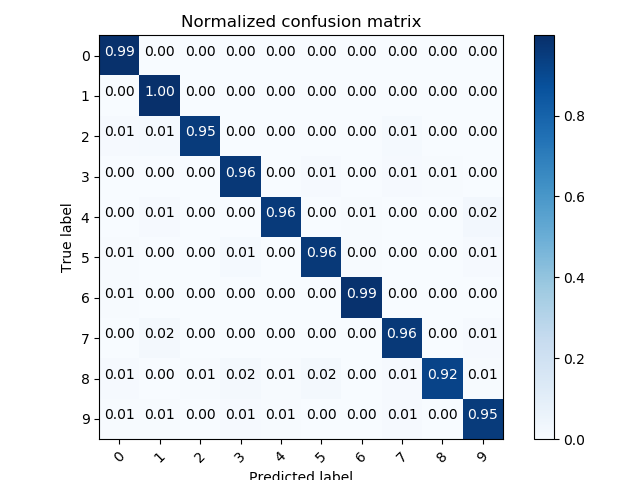

In [19]:
cnf_matrix = confusion_matrix(y_test_MN, results)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(10), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### CIFAR-10

In [20]:
%%time
knn = KNeighborsClassifier()
knn.fit(X_train_CF, y_train_CF.ravel())
results = knn.predict(X_test_CF)

Wall time: 36min 48s


In [21]:
print(metrics.classification_report(y_test_MN, results))

             precision    recall  f1-score   support

          0       0.11      0.16      0.13       980
          1       0.10      0.02      0.04      1135
          2       0.10      0.19      0.13      1032
          3       0.11      0.07      0.09      1010
          4       0.10      0.23      0.14       982
          5       0.09      0.05      0.07       892
          6       0.09      0.07      0.08       958
          7       0.13      0.04      0.06      1028
          8       0.09      0.16      0.11       974
          9       0.06      0.01      0.02      1009

avg / total       0.10      0.10      0.09     10000



<IPython.core.display.Javascript object>


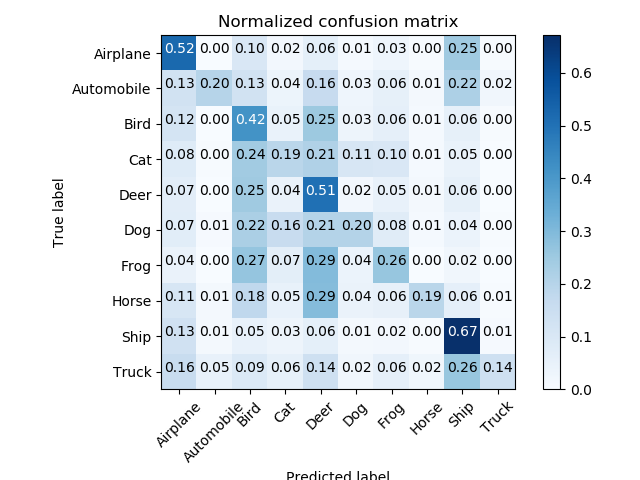

In [22]:
cnf_matrix = confusion_matrix(y_test_CF, results)
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes=['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck'], 
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Fig [3] shows the confusion matrix for the KNN classifier when applied to the MNIST dataset.  The classification results show an average F-1 score of 0.97, which shows that even when applying simple classification algorithm to the MNIST dataset we can expect accuracy close to 100%. The high accuracy can be explained by the intra-class similarity and the standardization of the dataset.

From the confusion matrix we can see that the classes that exhibited higher accuracy were the numbers 0, 1 and 6 with accuracies close to 1, while the others seemed to stay around 92%. This result could show that the numbers with higher accuracy present less variation when being handwritten.

Fig[4] shows the confusion matrix for the KNN classifier when applied to the CIFAR-10 dataset. In this case we see an average F-1 score of 0.09. The very low accuracy of the KNN 
classifier is explained by the characteristics of the dataset. The CIFAR-10 dataset contains images with different backgrounds, colors and illumination. Furthermore, the classes in the dataset are mostly semantic, while in the MNIST dataset there was a high structural similarity between the members of the same class. In CIFAR-10 even if two images are grouped together (eg. Two samples of the car class), that doesn’t mean that the structural characteristics of the image itself are similar (eg. different makes and models).  It them becomes evident that the KNN classifier falls short for this application
Fig[4] also shows that some classes presented much higher accuracies like the Airplane, Ship, Deer and Bird classes. This fact could be explained by the background of those images. One way to visualize the background effect would be to consider the Ship class. Most images in the Ship class would show some water content, which would lead to images with shades of blue and subsequently lead to test images closer to the blue color to be classified into ships.


# MLP - Neural Network Baseline

### MNIST

In [49]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [50]:
train_data_MN = X_train_MN/255
train_label_MN = y_train_MN

val_data_MN = X_val_MN/255
val_label_MN = y_val_MN

test_data_MN = X_test_MN/255
test_label_MN = y_test_MN

In [51]:
# one hot encode outputssco
train_label_MN = np_utils.to_categorical(train_label_MN)
test_label_MN = np_utils.to_categorical(test_label_MN)
val_label_MN = np_utils.to_categorical(val_label_MN)
num_classes = train_label_MN.shape[1]
num_pixels = train_data_MN.shape[1]

In [52]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [53]:
# build the model
model = baseline_model()
# Fit the model
model.fit(train_data_MN, train_label_MN, validation_data=(val_data_MN, val_label_MN), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(test_data_MN, test_label_MN, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
 - 5s - loss: 0.3228 - acc: 0.9077 - val_loss: 0.1732 - val_acc: 0.9516
Epoch 2/10
 - 4s - loss: 0.1356 - acc: 0.9616 - val_loss: 0.1297 - val_acc: 0.9608
Epoch 3/10
 - 4s - loss: 0.0881 - acc: 0.9753 - val_loss: 0.1054 - val_acc: 0.9697
Epoch 4/10
 - 4s - loss: 0.0615 - acc: 0.9830 - val_loss: 0.0951 - val_acc: 0.9713
Epoch 5/10
 - 4s - loss: 0.0447 - acc: 0.9880 - val_loss: 0.0850 - val_acc: 0.9741
Epoch 6/10
 - 4s - loss: 0.0324 - acc: 0.9916 - val_loss: 0.0800 - val_acc: 0.9761
Epoch 7/10
 - 4s - loss: 0.0244 - acc: 0.9943 - val_loss: 0.0774 - val_acc: 0.9761
Epoch 8/10
 - 4s - loss: 0.0175 - acc: 0.9965 - val_loss: 0.0741 - val_acc: 0.9775
Epoch 9/10
 - 4s - loss: 0.0134 - acc: 0.9975 - val_loss: 0.0734 - val_acc: 0.9771
Epoch 10/10
 - 4s - loss: 0.0092 - acc: 0.9987 - val_loss: 0.0755 - val_acc: 0.9787
Baseline Error: 1.85%


In [54]:
results = model.predict_classes(test_data_MN)

In [55]:
print(metrics.classification_report(y_test_MN, results))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       980
          1       0.99      0.99      0.99      1135
          2       0.98      0.98      0.98      1032
          3       0.99      0.98      0.98      1010
          4       0.96      0.99      0.97       982
          5       0.98      0.99      0.98       892
          6       0.98      0.98      0.98       958
          7       0.98      0.98      0.98      1028
          8       0.98      0.97      0.98       974
          9       0.99      0.96      0.98      1009

avg / total       0.98      0.98      0.98     10000



<IPython.core.display.Javascript object>


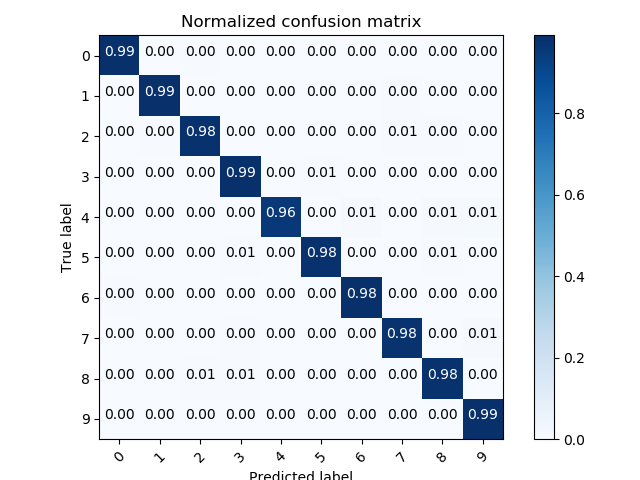

In [56]:
cnf_matrix = confusion_matrix(results, y_test_MN)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(10), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### CIFAR-10

In [57]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [58]:
train_data_CF = X_train_CF/255
train_label_CF = y_train_CF

val_data_CF = X_val_CF/255
val_label_CF = y_val_CF

test_data_CF = X_test_CF/255
test_label_CF = y_test_CF

In [59]:
# one hot encode outputssco
train_label_CF = np_utils.to_categorical(train_label_CF)
test_label_CF = np_utils.to_categorical(test_label_CF)
val_label_CF = np_utils.to_categorical(val_label_CF)
num_classes = train_label_CF.shape[1]
num_pixels = train_data_CF.shape[1]

In [60]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [61]:
# build the model
model = baseline_model()
# Fit the model
model.fit(train_data_CF, train_label_CF, validation_data=(val_data_CF, val_label_CF), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(test_data_CF, test_label_CF, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 35000 samples, validate on 15000 samples
Epoch 1/10
 - 54s - loss: 11.9725 - acc: 0.1727 - val_loss: 10.5484 - val_acc: 0.2387
Epoch 2/10
 - 55s - loss: 10.4345 - acc: 0.2131 - val_loss: 10.4096 - val_acc: 0.1900
Epoch 3/10
 - 54s - loss: 10.2265 - acc: 0.2262 - val_loss: 10.1311 - val_acc: 0.2357
Epoch 4/10
 - 54s - loss: 10.1873 - acc: 0.2296 - val_loss: 10.0549 - val_acc: 0.2478
Epoch 5/10
 - 54s - loss: 10.1161 - acc: 0.2387 - val_loss: 10.0909 - val_acc: 0.2373
Epoch 6/10
 - 54s - loss: 10.0948 - acc: 0.2441 - val_loss: 10.0656 - val_acc: 0.2441
Epoch 7/10
 - 54s - loss: 9.0478 - acc: 0.2674 - val_loss: 8.7211 - val_acc: 0.2685
Epoch 8/10
 - 54s - loss: 5.2816 - acc: 0.3065 - val_loss: 1.7488 - val_acc: 0.3728
Epoch 9/10
 - 54s - loss: 1.6714 - acc: 0.4059 - val_loss: 1.6713 - val_acc: 0.4029
Epoch 10/10
 - 54s - loss: 1.5920 - acc: 0.4345 - val_loss: 1.5894 - val_acc: 0.4383
Baseline Error: 56.07%


In [62]:
results = model.predict_classes(test_data_CF)

In [63]:
print(metrics.classification_report(y_test_CF, results))

             precision    recall  f1-score   support

          0       0.51      0.40      0.45      1000
          1       0.50      0.64      0.56      1000
          2       0.33      0.28      0.30      1000
          3       0.32      0.35      0.34      1000
          4       0.50      0.15      0.23      1000
          5       0.46      0.22      0.30      1000
          6       0.36      0.76      0.48      1000
          7       0.53      0.42      0.47      1000
          8       0.48      0.69      0.56      1000
          9       0.55      0.48      0.51      1000

avg / total       0.45      0.44      0.42     10000



<IPython.core.display.Javascript object>


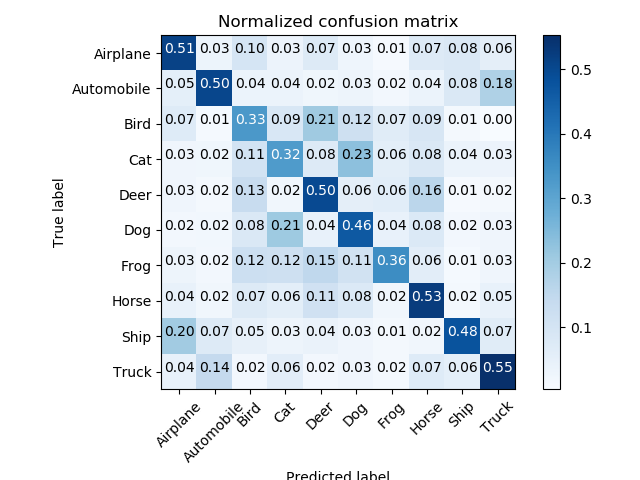

In [64]:
cnf_matrix = confusion_matrix(results, y_test_CF)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck'],
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In Fig[5] we  can see the results for the confusion matrix when applying the MLP classifier to the MNIST dataset. In this case we see an increase in the model’s accuracy leading to an average F-1 score of 0.98. 
The same increase in accuracy can be seem when applying the MLP classifier to the to the CIFAR-10 dataset. In this case we see an average F-1 score of 0.44, Fig[6].	

These results show that even when using simple network architectures, the neural network model yields better accuracy than a simple image comparison. On the other hand, we see that even with the increased accuracy, the model has a harder time distinguishing between the images in the CIFAR-10 dataset.


## Convolutional Neural Network

### MNIST

In [65]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [66]:
(X_train_MN, y_train_MN), (X_test_MN, y_test_MN) = mnist.load_data()
X_train_MN = X_train_MN.reshape(X_train_MN.shape[0], 1, 28, 28).astype('float32')
X_val_MN = X_val_MN.reshape(X_val_MN.shape[0], 1, 28, 28).astype('float32')
X_test_MN = X_test_MN.reshape(X_test_MN.shape[0], 1, 28, 28).astype('float32')

if sampling == True:
    X_train_MN = X_train_MN[:sample_size]
    y_train_MN = y_train_MN[:sample_size]
    
    X_val_MN = X_val_MN[:sample_size]
    y_val_MN = y_val_MN[:sample_size]
    
    X_test_MN = X_test_MN[:sample_size]
    y_test_MN = y_test_MN[:sample_size]

In [67]:
train_data_MN = X_train_MN/255
train_label_MN = y_train_MN

val_data_MN = X_val_MN/255
val_label_MN = y_val_MN

test_data_MN = X_test_MN/255
test_label_MN = y_test_MN

In [68]:
# one hot encode outputssco
train_label_MN = np_utils.to_categorical(train_label_MN)
test_label_MN = np_utils.to_categorical(test_label_MN)
val_label_MN = np_utils.to_categorical(val_label_MN)
num_classes = train_label_MN.shape[1]
num_pixels = train_data_MN.shape[1]

In [69]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [70]:
# build the model
model = baseline_model()
# Fit the model
model.fit(train_data_MN, train_label_MN, validation_data=(val_data_MN, val_label_MN), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(test_data_MN, test_label_MN, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 18000 samples
Epoch 1/10
 - 121s - loss: 0.2325 - acc: 0.9342 - val_loss: 0.0811 - val_acc: 0.9765
Epoch 2/10
 - 121s - loss: 0.0734 - acc: 0.9779 - val_loss: 0.0440 - val_acc: 0.9876
Epoch 3/10
 - 121s - loss: 0.0530 - acc: 0.9839 - val_loss: 0.0344 - val_acc: 0.9896
Epoch 4/10
 - 120s - loss: 0.0401 - acc: 0.9877 - val_loss: 0.0270 - val_acc: 0.9912
Epoch 5/10
 - 121s - loss: 0.0336 - acc: 0.9894 - val_loss: 0.0196 - val_acc: 0.9946
Epoch 6/10
 - 121s - loss: 0.0275 - acc: 0.9915 - val_loss: 0.0162 - val_acc: 0.9952
Epoch 7/10
 - 120s - loss: 0.0235 - acc: 0.9926 - val_loss: 0.0134 - val_acc: 0.9964
Epoch 8/10
 - 121s - loss: 0.0203 - acc: 0.9936 - val_loss: 0.0122 - val_acc: 0.9968
Epoch 9/10
 - 120s - loss: 0.0169 - acc: 0.9944 - val_loss: 0.0077 - val_acc: 0.9976
Epoch 10/10
 - 121s - loss: 0.0142 - acc: 0.9958 - val_loss: 0.0089 - val_acc: 0.9978
CNN Error: 0.94%


In [71]:
results = model.predict_classes(test_data_MN)

In [72]:
print(metrics.classification_report(y_test_MN, results))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99       980
          1       1.00      0.99      1.00      1135
          2       0.99      0.99      0.99      1032
          3       0.98      1.00      0.99      1010
          4       0.99      0.99      0.99       982
          5       1.00      0.98      0.99       892
          6       0.99      0.99      0.99       958
          7       0.99      0.99      0.99      1028
          8       0.99      0.98      0.99       974
          9       0.98      0.99      0.99      1009

avg / total       0.99      0.99      0.99     10000



<IPython.core.display.Javascript object>


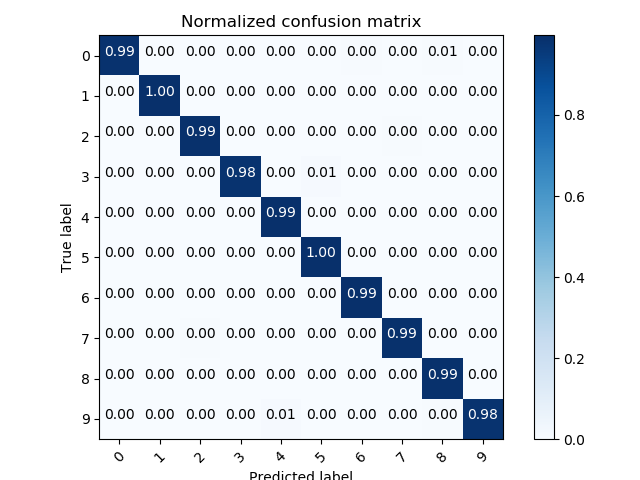

In [73]:
cnf_matrix = confusion_matrix(results, y_test_MN)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(10), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### CIFAR-10

In [74]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [75]:
(X_train_CF, y_train_CF), (X_test_CF, y_test_CF) = cifar10.load_data()
X_train_CF = X_train_CF.reshape(X_train_CF.shape[0], 3, 32, 32).astype('float32')
X_val_CF = X_val_CF.reshape(X_val_CF.shape[0], 3, 32, 32).astype('float32')
X_test_CF = X_test_CF.reshape(X_test_CF.shape[0], 3, 32, 32).astype('float32')

if sampling == True:
    X_train_CF = X_train_CF[:sample_size]
    y_train_CF = y_train_CF[:sample_size]
    
    X_val_CF = X_val_CF[:sample_size]
    y_val_CF = y_val_CF[:sample_size]
    
    X_test_CF = X_test_CF[:sample_size]
    y_test_CF = y_test_CF[:sample_size]

In [76]:
train_data_CF = X_train_CF/255
train_label_CF = y_train_CF

val_data_CF = X_val_CF/255
val_label_CF = y_val_CF

test_data_CF = X_test_CF/255
test_label_CF = y_test_CF

In [77]:
# one hot encode outputssco
train_label_CF = np_utils.to_categorical(train_label_CF)
test_label_CF = np_utils.to_categorical(test_label_CF)
val_label_CF = np_utils.to_categorical(val_label_CF)
num_classes = train_label_CF.shape[1]
num_pixels = train_data_CF.shape[1]

In [78]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(3, 32, 32), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [79]:
# build the model
model = baseline_model()
# Fit the model
model.fit(train_data_CF, train_label_CF, validation_data=(val_data_CF, val_label_CF), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(test_data_CF, test_label_CF, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 50000 samples, validate on 15000 samples
Epoch 1/10
 - 143s - loss: 1.7328 - acc: 0.3833 - val_loss: 3.7019 - val_acc: 0.0993
Epoch 2/10
 - 150s - loss: 1.3674 - acc: 0.5165 - val_loss: 4.1516 - val_acc: 0.1103
Epoch 3/10
 - 149s - loss: 1.2429 - acc: 0.5662 - val_loss: 4.3927 - val_acc: 0.1185
Epoch 4/10
 - 150s - loss: 1.1544 - acc: 0.5979 - val_loss: 4.5141 - val_acc: 0.1149
Epoch 5/10
 - 150s - loss: 1.0856 - acc: 0.6238 - val_loss: 4.3058 - val_acc: 0.1179
Epoch 6/10
 - 151s - loss: 1.0245 - acc: 0.6434 - val_loss: 4.4174 - val_acc: 0.1035
Epoch 7/10
 - 150s - loss: 0.9927 - acc: 0.6558 - val_loss: 4.6242 - val_acc: 0.1125
Epoch 8/10
 - 150s - loss: 0.9564 - acc: 0.6676 - val_loss: 4.5737 - val_acc: 0.1270
Epoch 9/10
 - 150s - loss: 0.9296 - acc: 0.6776 - val_loss: 4.7162 - val_acc: 0.1141
Epoch 10/10
 - 150s - loss: 0.9053 - acc: 0.6827 - val_loss: 4.6852 - val_acc: 0.1122
CNN Error: 34.53%


In [80]:
results = model.predict_classes(test_data_CF)

In [81]:
print(metrics.classification_report(y_test_CF, results))

             precision    recall  f1-score   support

          0       0.67      0.75      0.71      1000
          1       0.77      0.76      0.76      1000
          2       0.61      0.43      0.51      1000
          3       0.55      0.27      0.37      1000
          4       0.61      0.59      0.60      1000
          5       0.46      0.73      0.57      1000
          6       0.73      0.77      0.75      1000
          7       0.69      0.75      0.72      1000
          8       0.76      0.77      0.76      1000
          9       0.72      0.72      0.72      1000

avg / total       0.66      0.65      0.65     10000



<IPython.core.display.Javascript object>


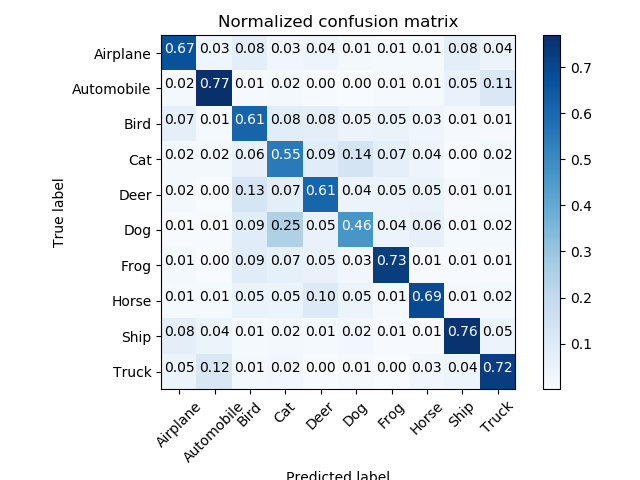

In [83]:
cnf_matrix = confusion_matrix(results, y_test_CF)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
                      , normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Fig[7] and Fig[8] shows the CNN confusion matrix results for the MNIST and CIFAR-10 datasets respectively. 

The use of CNN for image classification yielded an average F-1 score of 0.99 for the MNIST dataset and 0.65 for the CIFAR-10, which again shows a similar response to the MLP model, but with higher accuracy.	

# Conclusion

In this work we demonstrated that although the KNN classifier can be used for simple image classification, when applied to datasets with inter and intra-class variation, it yields poor results. 

By comparing the classifier performance on the MNIST dataset to the CIFAR-10, we can see the effects of image and background standardization on the classification accuracy. Moreover, classification of semantic classes seems to lead to lower accuracies than those from a structural image classification. 
    
When comparing the KNN, MLP and CNN models for image classification, CNN seem to yield the better results, with accuracies up to 6x higher than those of the other implementations. It’s important to note that the CNN network applied in this report has a simple architecture and presented a small number of layers. It has been demonstrated that the use of Larger Convolutional Neural Networks can yield state of the art classification results in these datasets [ref].	

# References

[1]	Yue C., An Y., Wu J., “CNNs for Face Detection and Recognition”, Starford Reports Cs231n, 2017. 

[2]	Razzak M.I., Naz S., Zaib A. (2018) Deep Learning for Medical Image Processing: Overview, Challenges and the Future. In: Dey N., Ashour A., Borra S. (eds) Classification in BioApps. Lecture Notes in Computational Vision and Biomechanics, vol 26. Springer, ChamL. E. Y. Herrera, R. M. Ribeiro, V. B. Jabulka, Pedro Tovar and J. P. von der Weid, “Photonic Generation and Transmission of Linearly Chirped Microwave Pulses with High TBWP by Self-Heterodyne Technique,” to be published in the Journal of Lightwave Technology, 2018.

[3]	Schmidhuber, et al, “Multi-Column Deep Neural Networks for Image Classification”, arXiv:1202.2745, 2012.

[4]	Cs231n.stanford.edu. (2018). Stanford University CS231n: Convolutional Neural Networks for Visual Recognition. [online] Available at: http://cs231n.stanford.edu/ [Accessed 2 Jul. 2018]..

[5]	 Brownlee, J. (2018). Handwritten Digit Recognition using Convolutional Neural Networks in Python with Keras. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/ [Accessed 2 Jul. 2018].


